# Problem 1
In this problem, we built a multilayer perceptron (MLP) and trained it on the MNIST handwritten digit dataset.

## Importing libraries

In [1]:
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Fixing random seed to ensure deterministic results
np.random.seed(2)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## 1.1 Building the Model

Code for forward and backward propagation, as well as for training the MLP was written in numpy (see below).

In [3]:
#Several functions in this class implementation are inspired from the NN implemented in cours IFT6093

class NN(object):
    
    '''
    Arguments:
        input_dim: The input dimension
        output_dim: The output dimension
        hidden_dims: (h1 dimension, h2 dimension)
        n_hidden: number of hidden layers
        initialization: type of weigth initialization (zeros, normal or glorot)
    
    '''
    
    def __init__(self, input_dim, output_dim,hidden_dims=(1024,2048),n_hidden=2,
                 initialization='zeros', mode=',train', datapath=None,
                 model_path=None):
        
        self.indim = input_dim
        self.hd1 = hidden_dims[0] 
        self.hd2 = hidden_dims[1]
        self.n_hidden = n_hidden
        self.outd = output_dim
        self.W1 = np.zeros(shape=(hidden_dims[0], input_dim))
        self.b1 = np.zeros(hidden_dims[0])
        self.W2 = np.zeros(shape=(hidden_dims[1], hidden_dims[0]))
        self.b2 = np.zeros(hidden_dims[1])
        self.W3 = np.zeros(shape=(output_dim, hidden_dims[1]))
        self.b3 = np.zeros(output_dim)
        
        
        if initialization=='normal':
            self.initialize_weights_normal()
            
        if initialization=='glorot':
            self.initialize_weights_glorot()
           
        self.parameters = [self.W3, self.b3, self.W2, self.b2, self.W1, self.b1]
        
        
    def initialize_weights_normal(self):
      
            
        self.W1 = np.random.standard_normal(size=(self.hd1, self.indim))
        self.W2 = np.random.standard_normal(size=(self.hd2, self.hd1))
        self.W3 = np.random.standard_normal(size=(self.outd, self.hd2))
        return self
    
    
    
    def initialize_weights_glorot(self):
        
        dl1 = np.sqrt(6/(self.indim + self.hd1))
        dl2 = np.sqrt(6/(self.hd1 + self.hd2))
        dl3 = np.sqrt(6/(self.hd2 + self.outd))
        self.W1 = np.random.uniform(low=(-dl1), high=dl1, size=(self.hd1, self.indim))
        self.W2 = np.random.uniform(low=(-dl2), high=dl2, size=(self.hd2, self.hd1))
        self.W3 = np.random.uniform(low=(-dl3), high=dl3, size=(self.outd, self.hd2))
        return self
        
        
    #Method from NN implemented in cours IFT6093
    
    def activation(self, x):
        return (x > 0) * x
    
    #line 85

    
    # forward for single exemple
    def forward(self,x):
                
        a1 = np.dot (self.W1, x) + self.b1 
        h1 = self.activation (a1)
        a2 = np.dot (self.W2, h1) + self.b2
        h2 = self.activation (a2)
        oa = np.dot (self.W3, h2) + self.b3
        os = self.softmax (oa, axis=0)
        
        return a1, h1, a2, h2, oa, os
    
    def setZero(self, a ):
        a[ np.abs( a ) <= zero ] = zero
        return a

    #Loss function using probability loss (cross entropie)
    def loss (self, y, os):
        return (y * (-np.log(os))).sum()
    
    #ans softmax methods from NN implemented in cours IFT6093
    
    def softmax(self, x, axis=1):
      e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
      return e_x / e_x.sum(axis=axis, keepdims=True)


    #Backward for single exemple
    def backward(self, x, y, a1, h1, a2, h2, oa, os, weight_decay=0, cache=None):
        
        grad_oa = os - y
        grad_W3 = np.outer (grad_oa, h2) + weight_decay * self.W3
        grad_b3 = grad_oa
        grad_h2 = np.dot (self.W3.T, grad_oa)
        grad_a2 = (a2 > 0) * grad_h2
        grad_W2 = np.outer (grad_a2, h1) + weight_decay * self.W2
        grad_b2 = grad_a2
        grad_h1 = np.dot (self.W2.T, grad_a2)
        grad_a1 = (a1 > 0) * grad_h1
        grad_W1 = np.outer (grad_a1, x) + weight_decay * self.W1
        grad_b1 = grad_a1
        grads=[grad_W3, grad_b3, grad_W2, grad_b2, grad_W1, grad_b1]
   
        return grads



    def update(self, grads, learning_rate):
        self.grads = grads
        for p, grad in zip(self.parameters, grads):
            p -= learning_rate * grad
        
    #line 201   

    #Sthocastic gradient descent method (litteral)
    def train_SGD(self, x, y_onehot, n, learning_rate=1e-1, weight_decay=0):
                
        y = y_onehot
        losses = 0
        if (n==1):
            a1, h1, a2, h2, oa, os = self.forward(x)
            grads = self.backward(x, y, a1, h1, a2, h2, oa, os)
            self.update(grads, learning_rate)
            loss = self.loss(y, os)
            losses += loss  
            average_loss = losses / x.shape[0]
        else:    
            for j in range(x.shape[0]):
                a1, h1, a2, h2, oa, os = self.forward(x[j])
                grads = self.backward(x[j], y[j], a1, h1, a2, h2, oa, os, weight_decay)
                self.update(grads, learning_rate)
                loss = self.loss(y[j], os)
                losses += loss     
            average_loss = losses / x.shape[0]
                
        return average_loss
    
    
    def prediction_SGD (self, x):
        predictions = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            _, _, _, _, _, os = self.forward(x[i])
            predictions[i] = os.argmax()
                
        return predictions
                
    
    def accuracy_SGD (self, prediction, y):
        accuracies=0
        for i in range (y.shape[0]):
            accuracies+=(prediction[i]==y[i])
            
        return accuracies / y.shape[0]
    
    
    def test_SGD(self, x, y_onehot, y):
        pred=np.zeros(y.shape[0])
        avg_loss=0
        for i in range (x.shape[0]):
            _, _, _, _, _, os = self.forward(x[i])
            loss=self.loss (y_onehot[i], os)
            avg_loss+=loss
            pred[i]=os.argmax()
            
        accuracy=self.accuracy_SGD(pred, y)    
        return avg_loss / x.shape[0] , accuracy
    
   
    #Sthocastic Gradien Descent method with minibatch (using matrices)
    def forward_mbatch(self, x):
                
        a1 = np.dot ( x, self.W1.T) + self.b1
        h1 = self.activation (a1)
        a2 = np.dot (h1, self.W2.T) + self.b2
        h2 = self.activation (a2)
        oa = np.dot (h2, self.W3.T) + self.b3
        os = self.softmax (oa, axis=1)
                
        return a1, h1, a2, h2, oa, os
    
    #line 303
        
    def backward_mbatch(self, x, y, a1, h1, a2, h2, oa, os, batch_n, weight_decay=0):
                
        batch_n = x.shape[0]
        bgrad_oa = os - y
        bgrad_W3 = np.dot (bgrad_oa.T, h2) / batch_n  + weight_decay * self.W3
        bgrad_b3 = bgrad_oa.mean(axis=0)
        bgrad_h2 = np.dot (bgrad_oa, self.W3)
        bgrad_a2 = (a2 > 0) * bgrad_h2
        bgrad_W2 = np.dot (bgrad_a2.T, h1) / batch_n  + weight_decay * self.W2
        bgrad_b2 = bgrad_a2.mean(axis=0)
        bgrad_h1 = np.dot (bgrad_a2, self.W2)
        bgrad_a1 = (a1 > 0) * bgrad_h1
        bgrad_W1 = np.dot (bgrad_a1.T, x) / batch_n  + weight_decay * self.W1
        bgrad_b1 = bgrad_a1.mean(axis=0)
        bgrads=[bgrad_W3, bgrad_b3, bgrad_W2, bgrad_b2, bgrad_W1, bgrad_b1]
   
        return bgrads

    #line 360

    #Method taken fron homwork 3 in cours IFT6093
    def loss_mbatch(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)     
        
    
    #training with minibatch gradient decent
    def train_mbatch(self, x, y_onehot, mb_size=100, learning_rate=1e-1, weight_decay=0):
                
        average_loss=0
        for i in range (0, x.shape[0], mb_size):
            xi = x[i:(i+mb_size)]
            yi = y_onehot[i:(i+mb_size)]
        
            #losses = 0
            a1, h1, a2, h2, oa, os = self.forward_mbatch(xi)
            grads = self.backward_mbatch (xi, yi,a1, h1, a2, h2,oa, os, mb_size,
                                          weight_decay)
            self.update(grads, learning_rate)
            average_loss += self.loss_mbatch(os, yi) 
                          
        return average_loss / mb_size
    
    
    #line 385
    
    def prediction_mbatch (self, x):
        _, _, _, _, _, os = self.forward_mbatch(x)
        return os.argmax(axis=1)
    

    def accuracy_mbatch (self, prediction, y):
        accuracy = np.zeros(y.shape[0])
        accuracy = prediction == y
        return accuracy.mean(axis=0)
    

    def test_mbatch(self, x, y_onehot, y):
        _, _, _, _, _, os = self.forward_mbatch(x)
        loss = self.loss_mbatch (os, y_onehot)
        accuracy=self.accuracy_mbatch (os.argmax(axis=1), y)
        return loss, accuracy
    
    
    def finite_difference():
        
        pass


### Data loading
Unzip and unpickle training, validation and test data

In [8]:
import gzip, pickle
#with gzip.open('gdrive/My Drive/mnist.pkl.gz','rb') as ff :
with gzip.open('mnist.pkl.gz','rb') as ff :
    u = pickle._Unpickler( ff )
    u.encoding = 'latin1'
    train, val, test = u.load()
    
X_tr, y_tr= train
X_v, y_v = val
X_t, y_t = test

Make data into numpy arrays and convert targets to one hot encoding

In [9]:
# train_data randomization
#indices_t = list(range(len(X_tr)))
#shuffle(indices_t)
#X_train, y_train=  X_tr[indices_t[:]], y_tr[indices_t[:]]

# validation_data randomization
#indices_v = list(range(len(X_v)))
#shuffle(indices_v)
#X_valid, y_valid = X_v[indices_v[:]], y_v[indices_v[:]]

#function taken from IFT6093 cours
def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

X_train = np.array (X_tr)
y_train = np.array (y_tr)
X_valid= np.array (X_v)
y_valid= np.array (y_v)
X_test = np.array (X_t)
y_test = np.array (y_t)


#geting onehot(y)
digit_y_train_onehot= onehot (y_train, 10)
digit_y_valid_onehot= onehot (y_valid, 10)
digit_y_test_onehot= onehot (y_test, 10)


print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_valid shape = ', X_valid.shape)
print('y_valid shape = ', y_valid.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (50000, 784)
y_train shape =  (50000,)
X_valid shape =  (10000, 784)
y_valid shape =  (10000,)
X_test shape =  (10000, 784)
y_test shape =  (10000,)


Set up function for plotting learning curves

In [0]:
#This function returns the learning curves grafics

def learning_curves(losses_train, accs_train, losses_valid, accs_valid,
                    h1, h2):
  
 
  plt.figure(figsize=(12, 4))
  axis = plt.subplot(1, 2, 1)
  axis.plot(range(1, epochs+1), losses_train, label='train')
  axis.plot(range(1, epochs+1), losses_valid, label='valid')
  
  axis.legend()
  axis.set_ylabel('Loss')
  axis.set_xlabel('Epochs')
  plt.title(('h_1 = ', h1, 'h_2 =', h2))
  
  
  axis = plt.subplot(1, 2, 2)
  axis.plot(range(1, epochs+1), accs_train, label='train')
  axis.plot(range(1, epochs+1), accs_valid, label='valid')
  
  axis.legend()
  axis.set_ylabel('Accuracy')
  axis.set_xlabel('Epochs')
  plt.title(('h_1 = ', h1, 'h_2 =', h2))
  


### Training the MLP using the probability loss (cross entropy) as training criterion.

In this part we use stochastic gradient descent to optimize the number of hidden units. We carry out a small grid search to find a network with between 0.5M and 1M parameters which performs well on the task.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Validation accuracy after 10 epoch training for h1=  500 h2 = 200 :  0.9764
Validation accuracy after 10 epoch training for h1=  500 h2 = 300 :  0.9784
Validation accuracy after 10 epoch training for h1=  800 h2 = 200 :  0.9782
Validation accuracy after 10 epoch training for h1=  800 h2 = 300 :  0.978


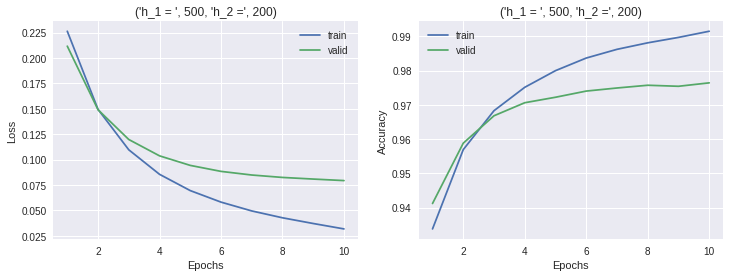

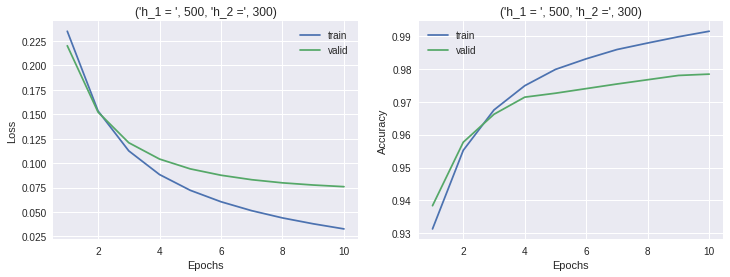

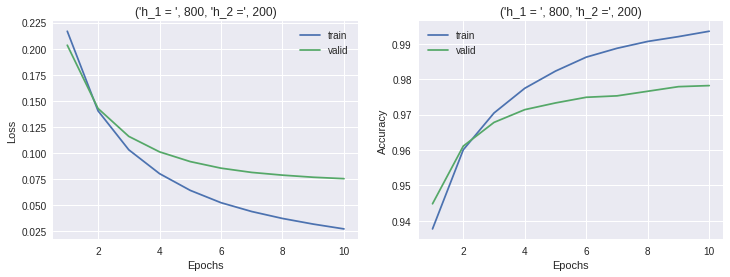

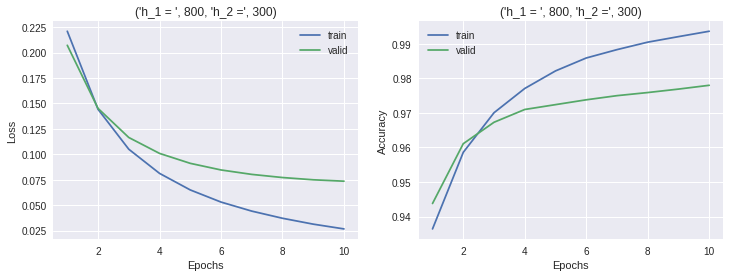

In [9]:
# Training the model with sthocastic gradient descent

zero=10**-15


for i, h1 in enumerate([500, 800]):
  
  for j, h2 in enumerate ([200, 300]):
  
  
    NN_SGD = NN(784, 10, hidden_dims=(h1, h2), initialization='glorot')
    
    # Model training 
    losses_train, accs_train = [], []
    losses_valid, accs_valid = [], []

    epochs=10

    for epoch in range (epochs):
  
      loss = NN_SGD.train_mbatch(X_train, digit_y_train_onehot, mb_size=100)

    #Test in validation and test set: test_mbatch(x_t, y_t_o, y_t)
    
      loss_train, acc_train = NN_SGD.test_mbatch(X_train, digit_y_train_onehot, y_train)
      loss_valid, acc_valid = NN_SGD.test_mbatch(X_valid, digit_y_valid_onehot, y_valid) 
      
    
      losses_train.append(loss_train) 
      accs_train.append(acc_train)
      losses_valid.append(loss_valid)
      accs_valid.append(acc_valid)
      
    valid_acc_epoc_90_100 = np.array(accs_valid[90:])
    valid_acc_mean_epoc_90_100 = valid_acc_epoc_90_100.mean()
      
    #print ('Mean validation accuracy from the last 10 epoch for h1= ', h1, 'h2 =', h2, ': ', valid_acc_mean_epoc_90_100)
    print ('Validation accuracy after 10 epoch training for h1= ', h1, 'h2 =', h2, ': ', acc_valid)
    
    learning_curves(losses_train, accs_train, losses_valid, accs_valid, h1, h2)

###  Conclusion: 
All configurations gave fairly high performance. The best configuration was h1=500, h2=300 achieving a mean accuracy 97.84 %. This model has a total of **545,810 parameters**. We use this model for the next step of comparing different initializations.

## 1.2 Initialization


We implemented and compared 3 initializations for the weight parameters of the MLP: zeros, standard Normal distribution and Glorot distribution. See code for the different initializations in *NN* class above.

Our MLP network was trained for 10 epochs using mini-batch gradient descent and minimizing the cross-entropy loss. 
* ReLU non-linearity was used as activation at each layer. 
* Learning rate was set to 1e-3.
* Mini-batch size was 50
* Model architecture: input dimensions = 784, h1=500, h2=300 (545,810 parameters)

Function to plot loss under different initialization weight types

In [0]:
def graf_initialization (epochs, zeros_losses, normal_losses, glorot_losses):
  fig = plt.figure()
  plt.plot(range(epochs),  zeros_losses, label='zeros')
  plt.plot(range(epochs), normal_losses, label='normal')
  plt.plot(range(epochs), glorot_losses, label='glorot')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
 
  plt.title("Initialization")

  plt.legend()
  plt.show()

Training with initialization: zeros, normal, glorot.

In [12]:
#1. Weigths initialization data from dataloader
zero=10**-15
print('Weigths initialization')

# Set timer
import time
start_time = time.time()

#training 10 epochs for each initialization type
epochs=10

zeros_losses=[]
normal_losses=[]
glorot_losses=[]
weigths=['zeros', 'normal', 'glorot']

for i, init in enumerate(weigths, 0):
    
    NN_digits= NN(784, 10, hidden_dims=(500,300), initialization=init)

    for epoch in range (epochs): 
    
        loss=NN_digits.train_mbatch(X_train, digit_y_train_onehot, mb_size=50, learning_rate=1e-3)
        if (init=='zeros'):
            zeros_losses.append(loss)
        if (init == 'normal'):
            normal_losses.append(loss)
        if (init == 'glorot'):
            glorot_losses.append(loss)
            
time_mb = time.time() - start_time
print('Time with minibatch gradient decent implementation: %f seconds\n' % time_mb)

Weigths initialization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:212: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in multiply


Time with minibatch gradient decent implementation: 952.224514 seconds



Plot results of experiments with different initial weights

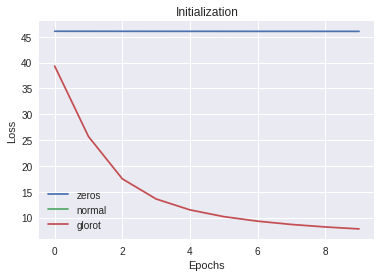

In [13]:
graf_initialization(epochs, zeros_losses, normal_losses, glorot_losses)

### Conclusion: 

From the plot above we could see that:
* Zero initialization did not result in any changes in gradients, then there was no optimization. It was clear that weights should not be initialized to zero as this makes it impossible to break symmetry when backpropagating.
* Normal initialization, moves slightly, but very soon behave in the same way as zero initialization. We suspect that this might be because it has mean=0.
* Glorot initialization promotes rapid change in gradients and allows optimization. This appears to be a very good strategy for weight initialisation

# =============================================================================================

## 1.3 Hyperparameter Search

Here we fix our initialization method as Glorot. And carry out a search over several combinations of hyperparameters. In particular, we essentially carry out a grid search by fixing other parameters at reasonable value and varying our parameters of interest. 

Having already selected our model architecture in section 1.1, we search through the following hyperparameters:
* Mini-batch size (50, 100, 150, 500)
* Learning rate (0.1,0.01,0.001)
* Weight decay

We train on the training set and use the validation set to select the value of hyperparameters at which validation set accuracy is highest.

Set up functions for hyperparameter search.

In [0]:
# Train the model using different hyperparameters, like mini-batch size, learning rate and epochs number
# x_ds is the dataset to train, y_ds is the target dataset.


def hyperparameter_checking(x_train_ds, y_train_ds, x_valid_ds, y_valid_ds, 
                            epochs,minibatch,learningrate, weight_decay=0, 
                            verbose=False):
  
    x = x_train_ds
    print('x.shape = ', x.shape)
    y = y_train_ds
    y = onehot(y,10)
    print('y.shape = ', y.shape)
    y_valid_onehot=onehot(y_valid_ds,10)
    
    # input_dim, output_dim,hidden_dims,n_hidden=2,mode=',train',
    # datapath=None,model_path=None
    NN_mbatch_1= NN(784, 10, hidden_dims=(500,300),initialization='glorot')
    
    losses_train, accs_train = [], []
    losses_valid, accs_valid = [], []
    
    for epoch in range (epochs): 
      
        #x, y_onehot, mb_size=100, learning_rate=1e-1, weight_decay=0
        loss_mbatch_1=NN_mbatch_1.train_mbatch(x, y, mb_size=minibatch,
                                               learning_rate=learningrate,
                                               weight_decay=weight_decay)
        if verbose:
            print('epoch ', epoch, ' loss ', loss_mbatch_1)
                   
        loss_train, accuracy_train=NN_mbatch_1.test_mbatch(x, y, y_train_ds)    
        loss_val, accuracy_val=NN_mbatch_1.test_mbatch(x_valid_ds, y_valid_onehot,
                                                       y_valid_ds)
        
        losses_train.append(loss_train)
        losses_valid.append(loss_val)
        accs_train.append(accuracy_train)
        accs_valid.append(accuracy_val)
        
    print('epoch ', epoch, ' loss ', loss_mbatch_1)
    return losses_train, losses_valid, accs_valid, accs_train, NN_mbatch_1 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Display differents graphs using different hyperparameters saved in arrays.
# Input variables are arrays with the same lenght, with the values to graph

def show_graphs(minibatch_arr,epoch_arr,learningrate_arr,loss_arr):
# define a list of markevery cases to plot
    cases=[]
    x_values=[]
    y_values=[]
    for i in range(len(minibatch_arr)):
        cases.append([minibatch_arr[i],epoch_arr[i],learningrate_arr[i]])
        # define the data for cartesian plots
        x_values.append(range(epoch_arr[i]))
        y_values.append(loss_arr[i])
    # define the figure size and grid layout properties
    figsize = (12, 10)
    cols = 2
    gs = gridspec.GridSpec(len(cases) // cols + 1, cols)
    gs.update(hspace=0.4)
    
    fig1 = plt.figure(num=1, figsize=figsize)
    ax = []
    for i, case in enumerate(cases):
        row = (i // cols)
        col = i % cols
        ax.append(fig1.add_subplot(gs[row, col]))
        ax[-1].set_title('Minibatch=%s, Epoch=%s, Learning=%s' % (str(case[0]),str(case[1]),str(case[2])))
        ax[-1].plot(x_values[i], y_values[i], 'o', ls='-', ms=4, markevery=1)

### Search for optimal *mini-batch size*
With different Mini-batch sizes (50,100,150,500), Epoch=10, Learning rate=0.1

In [0]:
x_ds=X_train
y_ds=y_train
x_valid_ds=X_valid
y_valid_ds=y_valid

In [93]:
loss_arr_0 = [] #training loss array
loss_arr_valid_0=[] #valid loss array
epoch_arr_0=[] #epoch array (save the epoch used on each mini-batch)
acc_arr_0=[] # accuracy with validation set array 
acc_train_0 = []
lr_0=1e-1 #learning rate used.
epoch_0=10 #total epoch

for i, minibatch in enumerate([50,100,150,500]):

    #losses_train, losses_valid, accs_valid, accs_train, NN_mbatch_1 
    loss_array, loss_array_valid, acc_valid, accs_train, nn_model = hyperparameter_checking(
        x_ds,y_ds,x_valid_ds,y_valid_ds,epoch_0,minibatch,lr_0)
    
    loss_arr_0.append(loss_array)
    loss_arr_valid_0.append(loss_array_valid)
    epoch_arr_0.append(epoch_0)
    acc_arr_0.append(acc_valid)
    acc_train_0.append(accs_train)
    
    print('Accuracy: %s' % str(acc_valid))

x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.22322833041258075
Accuracy: [0.9535, 0.9641, 0.9684, 0.9722, 0.9745, 0.9764, 0.9775, 0.9789, 0.9801, 0.9803]
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.17012616736020164
Accuracy: [0.9419, 0.9593, 0.9663, 0.9692, 0.9717, 0.9736, 0.9746, 0.9756, 0.976, 0.9764]
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.11832031917703138
Accuracy: [0.9257, 0.9515, 0.9603, 0.9659, 0.9697, 0.9718, 0.9737, 0.9747, 0.9757, 0.9769]
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.030001601954496845
Accuracy: [0.9017, 0.9197, 0.9295, 0.9384, 0.9448, 0.9501, 0.9535, 0.9568, 0.9587, 0.96]


In [0]:
epoch_arr_0=[10,10,10,10]

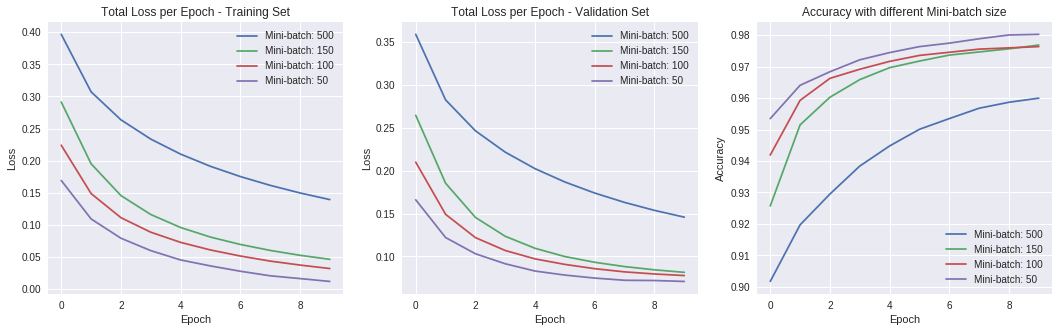

In [95]:
minibatch_arr=[50,100,150,500]
fig, ax = plt.subplots(1,3,figsize=(18, 5))
# plt.xlabel('Epoch')

ax[2].plot(range(epoch_arr_0[3]), acc_arr_0[3], label='Mini-batch: %s' % str(minibatch_arr[3]))
ax[2].plot(range(epoch_arr_0[3]), acc_arr_0[2], label='Mini-batch: %s' % str(minibatch_arr[2]))
ax[2].plot(range(epoch_arr_0[3]), acc_arr_0[1], label='Mini-batch: %s' % str(minibatch_arr[1]))
ax[2].plot(range(epoch_arr_0[3]), acc_arr_0[0], label='Mini-batch: %s' % str(minibatch_arr[0]))
ax[2].legend()
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Accuracy with different Mini-batch size')
ax[2].grid(True)

ax[0].plot(range(epoch_arr_0[3]), loss_arr_0[3], label='Mini-batch: %s' % str(minibatch_arr[3]))
ax[0].plot(range(epoch_arr_0[2]), loss_arr_0[2], label='Mini-batch: %s' % str(minibatch_arr[2]))
ax[0].plot(range(epoch_arr_0[1]), loss_arr_0[1], label='Mini-batch: %s' % str(minibatch_arr[1]))
ax[0].plot(range(epoch_arr_0[0]), loss_arr_0[0], label='Mini-batch: %s' % str(minibatch_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per Epoch - Training Set')

ax[1].plot(range(epoch_arr_0[3]), loss_arr_valid_0[3], label='Mini-batch: %s' % str(minibatch_arr[3]))
ax[1].plot(range(epoch_arr_0[2]), loss_arr_valid_0[2], label='Mini-batch: %s' % str(minibatch_arr[2]))
ax[1].plot(range(epoch_arr_0[1]), loss_arr_valid_0[1], label='Mini-batch: %s' % str(minibatch_arr[1]))
ax[1].plot(range(epoch_arr_0[0]), loss_arr_valid_0[0], label='Mini-batch: %s' % str(minibatch_arr[0]))
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per Epoch - Validation Set')

plt.show()

4


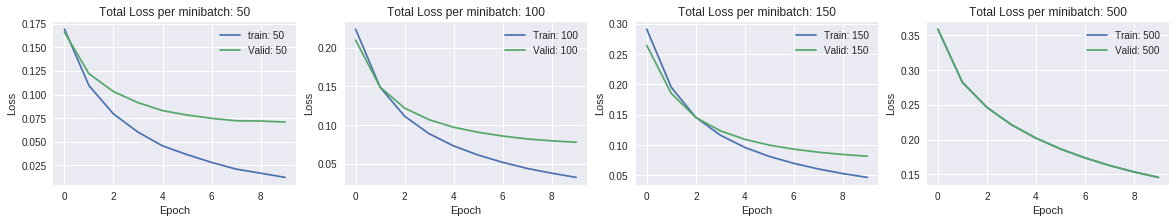

In [96]:
print(len(loss_arr_0)) 
  
minibatch_arr=[50,100,150,500]
fig, ax = plt.subplots(1,4,figsize=(20, 3))

plt.xlabel('Epoch')


ax[0].plot(range(epoch_arr_0[0]), loss_arr_0[0], label='train: %s' % str(minibatch_arr[0]))
ax[0].plot(range(epoch_arr_0[0]), loss_arr_valid_0[0], label='Valid: %s' % str(minibatch_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per minibatch: %s' % str(minibatch_arr[0]))

ax[1].plot(range(epoch_arr_0[1]), loss_arr_0[1], label='Train: %s' % str(minibatch_arr[1]))
ax[1].plot(range(epoch_arr_0[1]), loss_arr_valid_0[1], label='Valid: %s' % str(minibatch_arr[1]))
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per minibatch: %s' % str(minibatch_arr[1]))

ax[2].plot(range(epoch_arr_0[2]), loss_arr_0[2], label='Train: %s' % str(minibatch_arr[2]))
ax[2].plot(range(epoch_arr_0[2]), loss_arr_valid_0[2], label='Valid: %s' % str(minibatch_arr[2]))
ax[2].legend()
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Total Loss per minibatch: %s' % str(minibatch_arr[2]))

ax[3].plot(range(epoch_arr_0[3]), loss_arr_valid_0[3], label='Train: %s' % str(minibatch_arr[3]))
ax[3].plot(range(epoch_arr_0[3]), loss_arr_valid_0[3], label='Valid: %s' % str(minibatch_arr[3]))
ax[3].legend()
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].set_title('Total Loss per minibatch: %s' % str(minibatch_arr[3]))



plt.show()

### Observation
The loss on the validation set is lowest when we use for mini-batch size of **50**.

### Search for optimal *learning rate*
With different Learning Rates (0.1,0.01,0.001), Epoch=10, Minibath size=50

In [0]:
x_ds=X_train
y_ds=y_train
x_valid_ds=X_valid
y_valid_ds=y_valid

In [98]:
lr_arr_1=[] #learning rate array.

loss_arr_1=[]   #training loss array
loss_arr_valid_1=[] #valid loss array
epoch_arr_1=[] #epoch array (save the epoch used on each mini-batch)
acc_arr_1=[] # accuracy with validation set array 
acc_train_1 = [] # accuracy with training set array 
epoch_1=10  #total epoch 
mb=50

for i, learningrate in enumerate([0.1,0.01,0.001]):
    loss_array, loss_array_valid, acc_valid, accs_train, nn_model =hyperparameter_checking(
        x_ds,y_ds,x_valid_ds,y_valid_ds,epoch_1,mb,learningrate)
    
    loss_arr_1.append(loss_array)
    loss_arr_valid_1.append(loss_array_valid)
    epoch_arr_1.append(epoch_1)
    acc_arr_1.append(acc_valid)
    acc_train_1.append(accs_train)
    
    print('Accuracy: %s' % str(acc_valid))
    

x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.21030013975336662
Accuracy: [0.9542, 0.9659, 0.9713, 0.9739, 0.9753, 0.9765, 0.9777, 0.9788, 0.9788, 0.9789]
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  2.982939759648488
Accuracy: [0.9062, 0.9225, 0.9315, 0.9387, 0.9448, 0.9501, 0.9536, 0.9565, 0.9601, 0.9615]
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  7.820660849497893
Accuracy: [0.7386, 0.824, 0.8566, 0.8757, 0.8852, 0.8925, 0.897, 0.9006, 0.9036, 0.9065]


In [0]:
epoch_arr_1=[10,10,10]

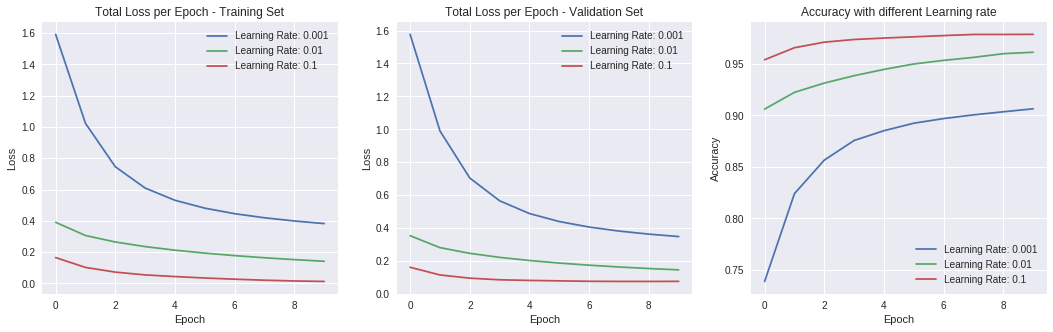

In [100]:

learningrate_arr=[0.1,0.01,0.001]
fig, ax = plt.subplots(1,3,figsize=(18, 5))
# plt.xlabel('Epoch')

ax[2].plot(range(epoch_arr_1[2]), acc_arr_1[2], label='Learning Rate: %s' % str(learningrate_arr[2]))
ax[2].plot(range(epoch_arr_1[1]), acc_arr_1[1], label='Learning Rate: %s' % str(learningrate_arr[1]))
ax[2].plot(range(epoch_arr_1[0]), acc_arr_1[0], label='Learning Rate: %s' % str(learningrate_arr[0]))
ax[2].legend()
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Accuracy with different Learning rate')
ax[2].grid(True)

ax[0].plot(range(epoch_arr_1[2]), loss_arr_1[2], label='Learning Rate: %s' % str(learningrate_arr[2]))
ax[0].plot(range(epoch_arr_1[1]), loss_arr_1[1], label='Learning Rate: %s' % str(learningrate_arr[1]))
ax[0].plot(range(epoch_arr_1[0]), loss_arr_1[0], label='Learning Rate: %s' % str(learningrate_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per Epoch - Training Set')

ax[1].plot(range(epoch_arr_1[2]), loss_arr_valid_1[2], label='Learning Rate: %s' % str(learningrate_arr[2]))
ax[1].plot(range(epoch_arr_1[1]), loss_arr_valid_1[1], label='Learning Rate: %s' % str(learningrate_arr[1]))
ax[1].plot(range(epoch_arr_1[0]), loss_arr_valid_1[0], label='Learning Rate: %s' % str(learningrate_arr[0]))
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per Epoch - Validation Set')

plt.show()

3


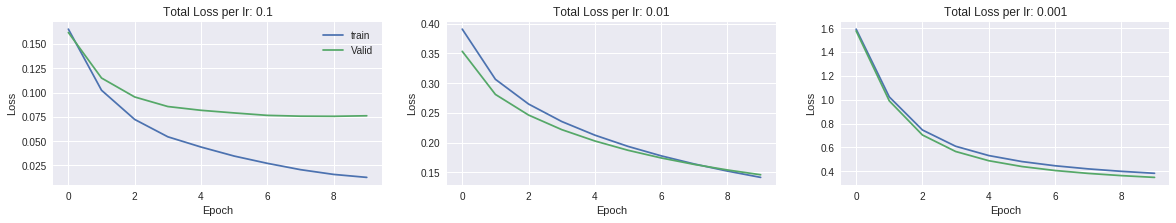

In [101]:
print(len(loss_arr_1)) 
  
learningrate_arr=[0.1,0.01,0.001]
fig, ax = plt.subplots(1,3,figsize=(20, 3))

plt.xlabel('Epoch')


ax[0].plot(range(epoch_arr_1[0]), loss_arr_1[0], label='train' )
ax[0].plot(range(epoch_arr_1[0]), loss_arr_valid_1[0], label='Valid') 
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per lr: %s' % str(learningrate_arr[0]))

ax[1].plot(range(epoch_arr_1[1]), loss_arr_1[1], label='Train: %s' % str(learningrate_arr[1]))
ax[1].plot(range(epoch_arr_1[1]), loss_arr_valid_1[1], label='Valid %s' % str(learningrate_arr[1]))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per lr: %s' % str(learningrate_arr[1]))

ax[2].plot(range(epoch_arr_1[2]), loss_arr_1[2], label='Train: %s' % str(learningrate_arr[2]))
ax[2].plot(range(epoch_arr_1[2]), loss_arr_valid_1[2], label='Valid: %s' % str(learningrate_arr[2]))
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Total Loss per lr: %s' % str(learningrate_arr[2]))




plt.show()

### Observation: 
Best accuracy on validation set was obtained with learning rate of 0.1.

### Search for optimal value of *weight decay*
Weight decay (0, 0.1, 0.01, 0.001), Epochs = 10, Learning Rates=0.1, Minibath size=50:

In [0]:
x_ds=X_train
y_ds=y_train
x_valid_ds=X_valid
y_valid_ds=y_valid

In [83]:
lr_arr_2=[] #learning rate array.
loss_arr_2=[]   #training loss array
loss_arr_valid_2=[] #valid loss array
epoch_arr_2=[] #epoch array (save the epoch used on each mini-batch)
acc_arr_2=[] # accuracy with validation set array 
acc_train_2 = [] # accuracy with training set array 

learning_rate=0.1
mb=50
epochs=10

for i, decay in enumerate([0, 0.1, 0.01, 0.001]):
  
    loss_array, loss_array_valid, acc_valid, accs_train, nn_model =hyperparameter_checking(
        x_ds,y_ds,x_valid_ds,y_valid_ds,epochs,mb,learning_rate, decay)
    
    loss_arr_2.append(loss_array)
    loss_arr_valid_2.append(loss_array_valid)
    epoch_arr_2.append(epochs)
    acc_arr_2.append(acc_valid)
    acc_train_2.append(accs_train)
    
    print('Accuracy: %s' % str(acc_valid))
    

x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.2094438415605569
Accuracy: [0.9551, 0.9673, 0.971, 0.9732, 0.975, 0.9765, 0.977, 0.9779, 0.9795, 0.9803]
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  18.00477740414336
Accuracy: [0.795, 0.796, 0.7977, 0.7979, 0.7989, 0.798, 0.7968, 0.7961, 0.7951, 0.7925]
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  4.321580930354562
Accuracy: [0.9321, 0.9412, 0.9456, 0.9474, 0.9489, 0.95, 0.9502, 0.9506, 0.9504, 0.9507]
x.shape =  (50000, 784)
y.shape =  (50000, 10)
epoch  9  loss  0.8524245183546193
Accuracy: [0.9526, 0.9622, 0.9672, 0.9701, 0.9716, 0.9727, 0.9741, 0.9747, 0.9752, 0.9756]


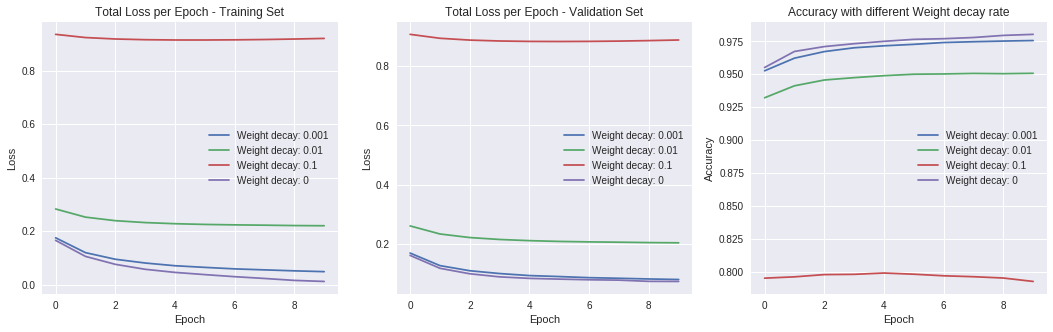

In [84]:
decay_arr=[0, 0.1, 0.01, 0.001]
fig, ax = plt.subplots(1,3,figsize=(18, 5))
# plt.xlabel('Epoch')
ax[2].plot(range(epoch_arr_2[3]), acc_arr_2[3], label='Weight decay: %s' % str(decay_arr[3]))
ax[2].plot(range(epoch_arr_2[2]), acc_arr_2[2], label='Weight decay: %s' % str(decay_arr[2]))
ax[2].plot(range(epoch_arr_2[1]), acc_arr_2[1], label='Weight decay: %s' % str(decay_arr[1]))
ax[2].plot(range(epoch_arr_2[0]), acc_arr_2[0], label='Weight decay: %s' % str(decay_arr[0]))
ax[2].legend()
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Accuracy with different Weight decay rate')
ax[2].grid(True)


ax[0].plot(range(epoch_arr_2[3]), loss_arr_2[3], label='Weight decay: %s' % str(decay_arr[3]))
ax[0].plot(range(epoch_arr_2[2]), loss_arr_2[2], label='Weight decay: %s' % str(decay_arr[2]))
ax[0].plot(range(epoch_arr_2[1]), loss_arr_2[1], label='Weight decay: %s' % str(decay_arr[1]))
ax[0].plot(range(epoch_arr_2[0]), loss_arr_2[0], label='Weight decay: %s' % str(decay_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per Epoch - Training Set')

ax[1].plot(range(epoch_arr_2[3]), loss_arr_valid_2[3], label='Weight decay: %s' % str(decay_arr[3]))
ax[1].plot(range(epoch_arr_2[2]), loss_arr_valid_2[2], label='Weight decay: %s' % str(decay_arr[2]))
ax[1].plot(range(epoch_arr_2[1]), loss_arr_valid_2[1], label='Weight decay: %s' % str(decay_arr[1]))
ax[1].plot(range(epoch_arr_2[0]), loss_arr_valid_2[0], label='Weight decay: %s' % str(decay_arr[0]))
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per Epoch - Validation Set')
plt.show()

4


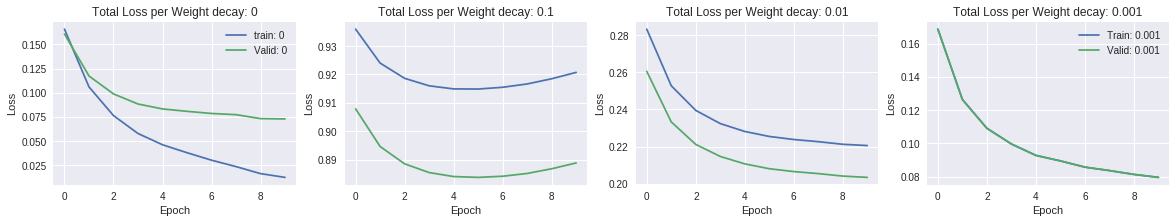

In [85]:
print(len(loss_arr_2)) 
  
decay_arr=[0, 0.1, 0.01, 0.001]
fig, ax = plt.subplots(1,4,figsize=(20, 3))

plt.xlabel('Epoch')


ax[0].plot(range(epoch_arr_2[0]), loss_arr_2[0], label='train: %s' % str(decay_arr[0]))
ax[0].plot(range(epoch_arr_2[0]), loss_arr_valid_2[0], label='Valid: %s' % str(decay_arr[0]))
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Total Loss per Weight decay: %s' % str(decay_arr[0]))

ax[1].plot(range(epoch_arr_2[1]), loss_arr_2[1], label='Train: %s' % str(decay_arr[1]))
ax[1].plot(range(epoch_arr_2[1]), loss_arr_valid_2[1], label='Vallid: %s' % str(decay_arr[1]))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Total Loss per Weight decay: %s' % str(decay_arr[1]))

ax[2].plot(range(epoch_arr_2[2]), loss_arr_2[2], label='Train: %s' % str(decay_arr[2]))
ax[2].plot(range(epoch_arr_2[2]), loss_arr_valid_2[2], label='Valid: %s' % str(decay_arr[2]))
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].set_title('Total Loss per Weight decay: %s' % str(decay_arr[2]))

ax[3].plot(range(epoch_arr_2[3]), loss_arr_valid_2[3], label='Train: %s' % str(decay_arr[3]))
ax[3].plot(range(epoch_arr_2[3]), loss_arr_valid_2[3], label='Valid: %s' % str(decay_arr[3]))
ax[3].legend()
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].set_title('Total Loss per Weight decay: %s' % str(decay_arr[3]))



plt.show()

### Observation:
Training the model without weight decay, that is weight decay = 0 gave the lowest loss on validation set.

### Conclusion: 
The best hyperparameters to train the model are Mini-batch size: 50, learning Rate: 0.1 and Weight decay = 0.

### Training the model with best hyperparameter settings
Mini-batch size=50,  Learning rate=0.1,  weigth decay = 0, epoch = 10 

In [0]:
loss_arr=[]
epochs=10
mb=50
lr=1e-1
decay = 0
x=X_train
y=onehot(y_train,10)
# input_dim, output_dim,hidden_dims,n_hidden=2,mode=',train',
# datapath=None,model_path=None
NN_mnist= NN(784, 10, hidden_dims=(500,300),initialization='glorot')
for epoch in range (epochs): 
    #x, y_onehot, mb_size=100, learning_rate=1e-1, weight_decay=0
    loss_mbatch_1=NN_mnist.train_mbatch(x, y, mb, lr, decay )
    

### The test set accuracy obtained by our best model is **97.96%**

In [87]:

loss_test, accuracy_test=NN_mnist.test_mbatch (X_test, digit_y_test_onehot, y_test)

print('loss test =', loss_test)

print('accuracy_test =', accuracy_test)

loss test = 0.07126066135735905
accuracy_test = 0.9796


### Getting the predictions for test set:

In [0]:
mnist_predicction = NN_mnist.prediction_mbatch(X_test)

np.savetxt("gdrive/My Drive/mnist_prediction_new.csv", mnist_predicction, delimiter=",")

# =============================================================================================

## 1.4 Finite difference

We used the method of finite differences to estimate the gradients in order to verify that gradients in our network are computed correctly. We used 10 units in layer 2 of the network to verify this.

### Initialise variables and function to be used.

In [19]:
# Finite difference
np.random.seed(42)
layer_idx = 2
no_of_units = 10
weight_idx = 2
batch_size = 1

def create_neural_net():
    h1 = 500
    h2 = 300
    n_i = 784
    n_o = 10
    init = 'glorot'
    return NN(n_i, n_o, hidden_dims=(h1, h2), initialization=init)

### a. Compute forward and backward pass to get the loss and gradients, using the expression for derivative.

In [20]:
# Compute forward pass to get the loss and gradients, using the expression for derivative.
np.random.seed(42)

neural_net = create_neural_net()

for i in range(1):
    loss = neural_net.train_mbatch(X_train[:1,:], digit_y_train_onehot[:1,:], mb_size=batch_size)
    print('loss: ', loss)

layer2_weights_grads = neural_net.grads[layer_idx]
print('Weight 2 - gradients: {0}\t gradient size: {1}'.format(layer2_weights_grads[:no_of_units,weight_idx], 
                                                              layer2_weights_grads.shape))
true_grads = layer2_weights_grads[:no_of_units,weight_idx]

loss:  2.2236260359771713
weight 2 - gradients: [ 0.         -0.0057863  -0.02705646  0.03199037 -0.01869665  0.
  0.          0.          0.          0.        ]	 gradient size: (300, 500)


### b. Compute gradients of same units via finite difference

True gradient is:  [ 0.         -0.0057863  -0.02705646  0.03199037 -0.01869665  0.
  0.          0.          0.          0.        ]
Using epsilon= 1.0
gradient (by finite diff):  [ 0.         -0.00578687 -0.02705563  0.02316275 -0.01223081  0.
  0.         -0.00113394  0.0089733   0.        ]
Using epsilon= 0.2
gradient (by finite diff):  [ 0.         -0.00578632 -0.02705642  0.0319904  -0.01869664  0.
  0.          0.          0.          0.        ]
Using epsilon= 0.1
gradient (by finite diff):  [ 0.         -0.0057863  -0.02705645  0.03199038 -0.01869665  0.
  0.          0.          0.          0.        ]
Using epsilon= 0.02
gradient (by finite diff):  [ 0.         -0.0057863  -0.02705646  0.03199037 -0.01869665  0.
  0.          0.          0.          0.        ]
Using epsilon= 0.01
gradient (by finite diff):  [ 0.         -0.0057863  -0.02705646  0.03199037 -0.01869665  0.
  0.          0.          0.          0.        ]
Using epsilon= 0.002
gradient (by finite diff):  [ 0. 

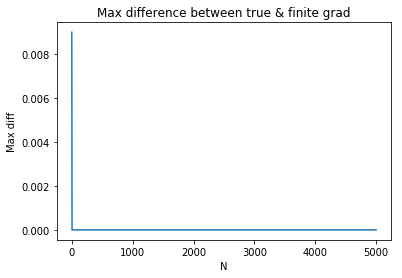

In [21]:
# Compute gradients of same units via finite difference
np.random.seed(42)

N = np.array([1, 5, 10, 50, 100, 500, 1000, 5000])
epsilon = 1/N

print('True gradient is: ', true_grads)

max_diff_per_e = []
for e in epsilon:
    print('Using epsilon=', e)
    
    # repeat for number units we want to evaluate.
    finite_diff_grads = []
    for i in range(no_of_units):
        np.random.seed(42)
        
        # create neural net, add epsilon to nn parameter at current index, and compute loss
        neural_net_2 = create_neural_net()
        nn2_weight_params = neural_net_2.parameters[layer_idx]
        #print(nn2_weight_params[:no_of_units, weight_idx])
        
        nn2_weight_params[i, weight_idx] += e
        loss_plus_e = neural_net_2.train_mbatch(X_train[:1,:], digit_y_train_onehot[:1,:], mb_size=batch_size)
        # print('loss_plus_e: ', loss_plus_e)
    
        np.random.seed(42)
        
        # create neural net, subtract epsilon to nn parameter at current index, and compute loss
        neural_net_3 = create_neural_net()
        nn3_weight_params = neural_net_3.parameters[layer_idx]
        # print(nn3_weight_params[:no_of_units, weight_idx])

        nn3_weight_params[i, weight_idx] -= e
        loss_minus_e = neural_net_3.train_mbatch(X_train[:1,:], digit_y_train_onehot[:1,:], mb_size=batch_size)
        # print('loss_minus_e: ', loss_minus_e)

        finite_diff = (loss_plus_e - loss_minus_e) / (2 * e)
        finite_diff_grads.append(finite_diff)
     
    finite_diff_grads = np.array(finite_diff_grads)
    print('gradient (by finite diff): ', finite_diff_grads)
    
    # get the max of the absolute difference between the true gradient and finite diff grad.
    #non_zero_idx = true_grads != 0
    max_diff = np.max(finite_diff_grads - true_grads)
    max_diff_per_e.append(max_diff)

print('maximum difference per e', max_diff_per_e)

plt.figure()
plt.plot(N, max_diff_per_e)
plt.xlabel('N')
plt.ylabel('Max diff')
plt.title('Max difference between true & finite grad')
plt.show()

### Conclusion:
* From the printed gradients, we see that using the methods of finite difference we approximate well the gradient of the 10 selected units.
* From the plot it can be seen that for epsilon = 1 (N = 1), there is some error between the true gradient and that computed by finite difference. But for small values of epsilon < 0.2 (ie N > 5), the finite difference gradients approximates the true gradient very well, leading to a maximum difference of almost zero.